In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the JSON file
json_file_path = r"D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/stentframe_fixed_gaps_BODYLINKED_20250906_210921.json"

with open(json_file_path, 'r') as f:
    data = json.load(f)

# Extract parameters
parameters = data.get('parameters', {})
print("Parameters:")
for key, value in parameters.items():
    print(f"  {key}: {value}")

print(f"\nTotal diameter: {parameters.get('diameter_mm', 'N/A')} mm")
print(f"Total length: {parameters.get('length_mm', 'N/A')} mm")
print(f"Number of rings: {parameters.get('num_rings', 'N/A')}")
print(f"Crowns per ring: {parameters.get('crowns_per_ring', 'N/A')}")

Parameters:
  diameter_mm: 1.8
  length_mm: 8.0
  num_rings: 6
  crowns_per_ring: 8
  angle_per_crown_deg: 45.0

Total diameter: 1.8 mm
Total length: 8.0 mm
Number of rings: 6
Crowns per ring: 8


In [4]:
# Extract wave data
wave_data = data.get('wave_inputs_by_column', [])
print(f"\nFound {len(wave_data)} wave data entries")

# Convert to DataFrame for easier analysis
df = pd.DataFrame(wave_data)
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# Check unique rings and columns
rings = sorted(df['ring'].unique())
print(f"\nRings: {rings}")

for ring in rings:
    ring_data = df[df['ring'] == ring]
    cols = sorted(ring_data['col'].unique())
    print(f"Ring {ring}: columns {min(cols)} to {max(cols)} ({len(cols)} total)")


Found 48 wave data entries

Columns: ['ring', 'col', 'wave_height_mm', 'wave_width_mm', 'strut_width_mm', 'gap_above_mm', 'gap_below_mm', 'linked_above', 'linked_below', 'upper_chord_center_mm', 'upper_sagitta_center_mm', 'upper_outer_sagitta_mm', 'lower_chord_center_mm', 'lower_sagitta_center_mm', 'lower_outer_sagitta_mm', 'theta_deg', 'Rc_mm']

First few rows:
   ring  col  wave_height_mm  wave_width_mm  strut_width_mm  gap_above_mm  \
0     1    0        1.363810       0.706858            0.06           NaN   
1     1    1        1.391429       0.706858            0.06           NaN   
2     1    2        1.365714       0.706858            0.06           NaN   
3     1    3        1.391429       0.706858            0.06           NaN   
4     1    4        1.363810       0.706858            0.06           NaN   

   gap_below_mm  linked_above  linked_below  upper_chord_center_mm  \
0         0.175           NaN           1.0               0.299583   
1         0.095           NaN  

In [5]:
# Calculate Y positions for each ring and cell
def calculate_cell_positions(df):
    """
    Calculate top and bottom Y-coordinates for each cell based on wave heights and gaps
    """
    results = []
    rings = sorted(df['ring'].unique())
    
    # Start from Y = 0 at the bottom
    current_y = 0
    ring_positions = {}
    
    for ring_num in rings:
        ring_data = df[df['ring'] == ring_num].copy()
        
        # Get the maximum wave height for this ring
        max_wave_height = ring_data['wave_height_mm'].max()
        
        # Get the maximum gap below for this ring (for spacing to next ring)
        max_gap_below = ring_data['gap_below_mm'].max() if 'gap_below_mm' in ring_data.columns else 0
        
        # Calculate ring boundaries
        ring_bottom = current_y
        ring_top = current_y + max_wave_height
        ring_center_y = current_y + max_wave_height / 2
        
        # Store ring info
        ring_positions[ring_num] = {
            'bottom': ring_bottom,
            'top': ring_top,
            'center': ring_center_y,
            'height': max_wave_height,
            'gap_below': max_gap_below
        }
        
        # Process each cell in this ring
        for _, row in ring_data.iterrows():
            cell_height = row['wave_height_mm']
            
            # For cells shorter than the ring height, center them vertically
            cell_bottom = ring_center_y - cell_height / 2
            cell_top = ring_center_y + cell_height / 2
            
            cell_info = {
                'ring': row['ring'],
                'col': row['col'],
                'wave_height_mm': cell_height,
                'wave_width_mm': row['wave_width_mm'],
                'cell_bottom_y': cell_bottom,
                'cell_top_y': cell_top,
                'cell_center_y': ring_center_y,
                'ring_bottom': ring_bottom,
                'ring_top': ring_top,
                'ring_height': max_wave_height
            }
            
            # Add gap information if available
            if 'gap_above_mm' in row:
                cell_info['gap_above_mm'] = row['gap_above_mm']
            if 'gap_below_mm' in row:
                cell_info['gap_below_mm'] = row['gap_below_mm']
                
            results.append(cell_info)
        
        # Move to next ring position (add ring height + gap)
        current_y += max_wave_height + max_gap_below
        
        print(f"Ring {ring_num}: Y {ring_bottom:.3f} to {ring_top:.3f} mm (height: {max_wave_height:.3f} mm, gap below: {max_gap_below:.3f} mm)")
    
    return pd.DataFrame(results), ring_positions

# Calculate positions
cell_positions_df, ring_info = calculate_cell_positions(df)

print(f"\nCalculated positions for {len(cell_positions_df)} cells")
print(f"Total stent length (calculated): {max(cell_positions_df['ring_top']):.3f} mm")
print(f"Total stent length (from parameters): {parameters.get('length_mm', 'N/A')} mm")

Ring 1: Y 0.000 to 1.395 mm (height: 1.395 mm, gap below: 0.175 mm)
Ring 2: Y 1.570 to 2.733 mm (height: 1.163 mm, gap below: 0.170 mm)
Ring 3: Y 2.903 to 4.066 mm (height: 1.163 mm, gap below: 0.170 mm)
Ring 4: Y 4.236 to 5.398 mm (height: 1.163 mm, gap below: 0.170 mm)
Ring 5: Y 5.568 to 6.731 mm (height: 1.163 mm, gap below: 0.175 mm)
Ring 6: Y 6.906 to 8.185 mm (height: 1.279 mm, gap below: nan mm)

Calculated positions for 48 cells
Total stent length (calculated): 8.185 mm
Total stent length (from parameters): 8.0 mm


In [6]:
# Display detailed cell positions
print("\nDetailed Cell Positions (first 10 cells):")
print(cell_positions_df[['ring', 'col', 'wave_height_mm', 'cell_bottom_y', 'cell_top_y', 'cell_center_y']].head(10))

# Summary by ring
print("\nSummary by Ring:")
ring_summary = cell_positions_df.groupby('ring').agg({
    'cell_bottom_y': ['min', 'max'],
    'cell_top_y': ['min', 'max'],
    'wave_height_mm': ['min', 'max', 'mean'],
    'col': 'count'
}).round(3)

ring_summary.columns = ['Cell_Bottom_Min', 'Cell_Bottom_Max', 'Cell_Top_Min', 'Cell_Top_Max', 
                       'Wave_Height_Min', 'Wave_Height_Max', 'Wave_Height_Avg', 'Num_Cells']
print(ring_summary)

# Check for any overlapping cells within rings
print("\nChecking for cell overlaps within rings:")
for ring in sorted(cell_positions_df['ring'].unique()):
    ring_cells = cell_positions_df[cell_positions_df['ring'] == ring].copy()
    
    # Sort by column
    ring_cells = ring_cells.sort_values('col')
    
    min_bottom = ring_cells['cell_bottom_y'].min()
    max_top = ring_cells['cell_top_y'].max()
    height_variation = max_top - min_bottom
    
    if height_variation > 0.001:  # More than 1 micron variation
        print(f"  Ring {ring}: Y variation {height_variation:.3f} mm (cells {min_bottom:.3f} to {max_top:.3f})")
    else:
        print(f"  Ring {ring}: All cells aligned (Y: {min_bottom:.3f} to {max_top:.3f})")


Detailed Cell Positions (first 10 cells):
   ring  col  wave_height_mm  cell_bottom_y  cell_top_y  cell_center_y
0   1.0  0.0        1.363810       0.015714    1.379524       0.697619
1   1.0  1.0        1.391429       0.001904    1.393334       0.697619
2   1.0  2.0        1.365714       0.014762    1.380476       0.697619
3   1.0  3.0        1.391429       0.001904    1.393334       0.697619
4   1.0  4.0        1.363810       0.015714    1.379524       0.697619
5   1.0  5.0        1.391429       0.001904    1.393334       0.697619
6   1.0  6.0        1.365714       0.014762    1.380476       0.697619
7   1.0  7.0        1.395238       0.000000    1.395238       0.697619
8   2.0  0.0        1.136508       1.583333    2.719841       2.151587
9   2.0  1.0        1.159524       1.571825    2.731349       2.151587

Summary by Ring:
      Cell_Bottom_Min  Cell_Bottom_Max  Cell_Top_Min  Cell_Top_Max  \
ring                                                                 
1.0             0.

C:\Users\fsuri\AppData\Local\Temp\ipykernel_16344\3712776711.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(ring_heights, labels=ring_labels)


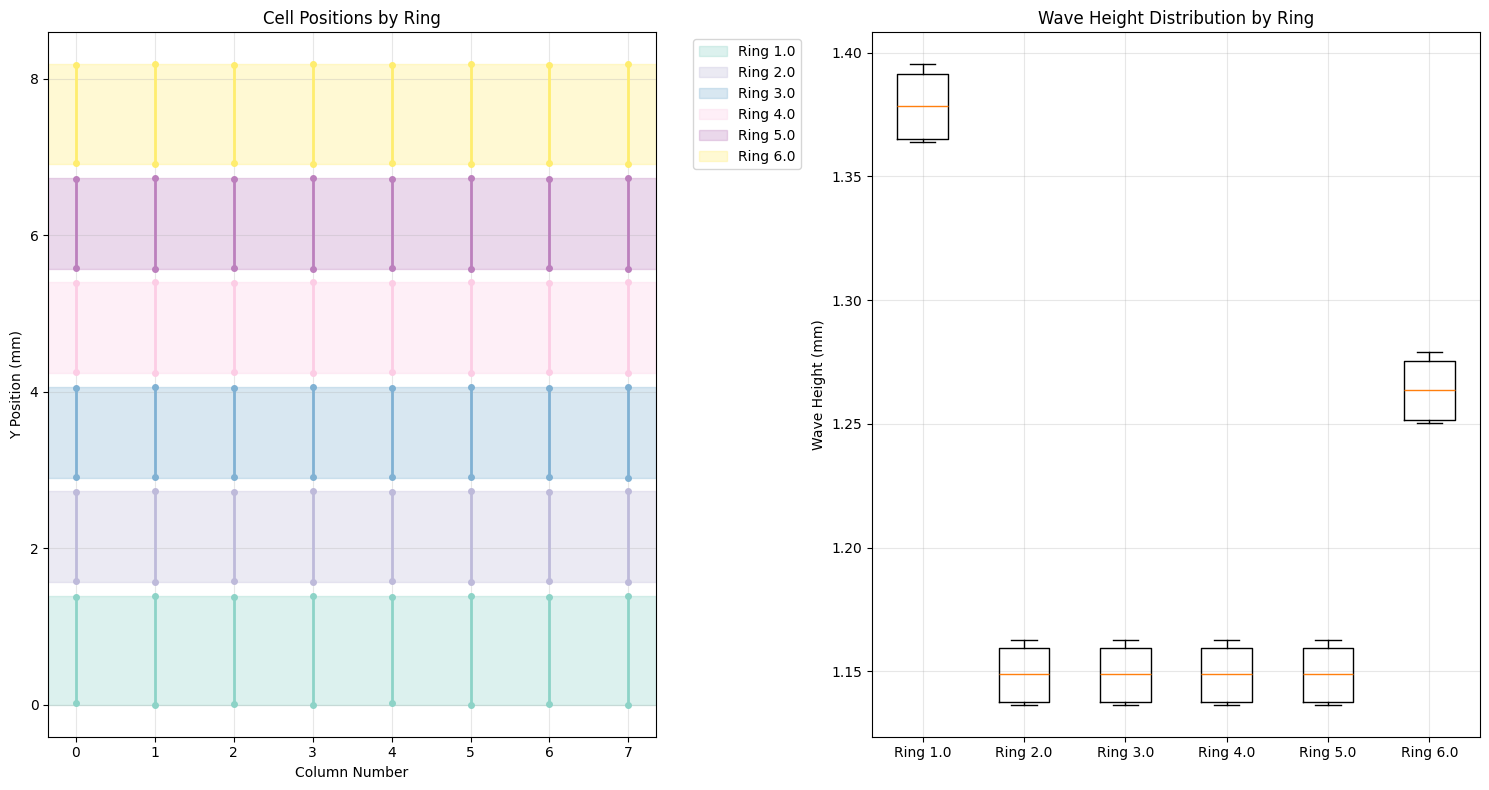


Summary Statistics:
Total calculated stent length: 8.185 mm
Parameter stent length: 8.0 mm
Number of rings: 6
Total number of cells: 48
Average cells per ring: 8.0

Wave Height Statistics:
Minimum wave height: 1.137 mm
Maximum wave height: 1.395 mm
Average wave height: 1.206 mm
Wave height std dev: 0.090 mm


In [7]:
# Create visualization of cell positions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot 1: Ring layout overview
rings = sorted(cell_positions_df['ring'].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(rings)))

for i, ring in enumerate(rings):
    ring_cells = cell_positions_df[cell_positions_df['ring'] == ring]
    
    # Plot ring boundaries
    ring_bottom = ring_cells['ring_bottom'].iloc[0]
    ring_top = ring_cells['ring_top'].iloc[0]
    
    ax1.axhspan(ring_bottom, ring_top, alpha=0.3, color=colors[i], label=f'Ring {ring}')
    
    # Plot individual cells
    for _, cell in ring_cells.iterrows():
        ax1.plot([cell['col'], cell['col']], [cell['cell_bottom_y'], cell['cell_top_y']], 
                'o-', color=colors[i], markersize=4, linewidth=2)

ax1.set_xlabel('Column Number')
ax1.set_ylabel('Y Position (mm)')
ax1.set_title('Cell Positions by Ring')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Wave height distribution
ring_heights = []
ring_labels = []
for ring in rings:
    ring_cells = cell_positions_df[cell_positions_df['ring'] == ring]
    ring_heights.append(ring_cells['wave_height_mm'].values)
    ring_labels.append(f'Ring {ring}')

ax2.boxplot(ring_heights, labels=ring_labels)
ax2.set_ylabel('Wave Height (mm)')
ax2.set_title('Wave Height Distribution by Ring')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Total calculated stent length: {cell_positions_df['ring_top'].max():.3f} mm")
print(f"Parameter stent length: {parameters.get('length_mm', 'N/A')} mm")
print(f"Number of rings: {len(rings)}")
print(f"Total number of cells: {len(cell_positions_df)}")
print(f"Average cells per ring: {len(cell_positions_df) / len(rings):.1f}")

# Wave height statistics
print(f"\nWave Height Statistics:")
print(f"Minimum wave height: {cell_positions_df['wave_height_mm'].min():.3f} mm")
print(f"Maximum wave height: {cell_positions_df['wave_height_mm'].max():.3f} mm")
print(f"Average wave height: {cell_positions_df['wave_height_mm'].mean():.3f} mm")
print(f"Wave height std dev: {cell_positions_df['wave_height_mm'].std():.3f} mm")

In [8]:
# Export calculated positions to CSV for use in other applications
output_file = r"D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/calculated_cell_positions.csv"

# Prepare export data with all relevant information
export_df = cell_positions_df.copy()

# Add some additional calculated fields
export_df['cell_height_mm'] = export_df['wave_height_mm']
export_df['ring_relative_bottom'] = export_df['cell_bottom_y'] - export_df['ring_bottom']
export_df['ring_relative_top'] = export_df['cell_top_y'] - export_df['ring_bottom']
export_df['ring_relative_center'] = export_df['cell_center_y'] - export_df['ring_bottom']

# Reorder columns for clarity
column_order = [
    'ring', 'col', 
    'wave_height_mm', 'wave_width_mm',
    'cell_bottom_y', 'cell_top_y', 'cell_center_y',
    'ring_bottom', 'ring_top', 'ring_height',
    'ring_relative_bottom', 'ring_relative_top', 'ring_relative_center'
]

# Add gap columns if they exist
if 'gap_above_mm' in export_df.columns:
    column_order.append('gap_above_mm')
if 'gap_below_mm' in export_df.columns:
    column_order.append('gap_below_mm')

export_df = export_df[column_order]

# Save to CSV
export_df.to_csv(output_file, index=False, float_format='%.6f')
print(f"\nExported {len(export_df)} cell positions to: {output_file}")

# Display sample of export data
print(f"\nSample of exported data:")
print(export_df.head(10).round(3))

# Create a summary for each ring showing the Y-coordinate ranges
print(f"\nRing Y-Coordinate Summary:")
print("=" * 80)
print(f"{'Ring':<6} {'Bottom':<10} {'Top':<10} {'Height':<10} {'Cells':<6} {'Gap Below':<10}")
print("=" * 80)

for ring in rings:
    ring_data = export_df[export_df['ring'] == ring]
    ring_bottom = ring_data['ring_bottom'].iloc[0]
    ring_top = ring_data['ring_top'].iloc[0]
    ring_height = ring_data['ring_height'].iloc[0]
    num_cells = len(ring_data)
    gap_below = ring_data['gap_below_mm'].iloc[0] if 'gap_below_mm' in ring_data.columns else 0
    
    print(f"{ring:<6} {ring_bottom:<10.3f} {ring_top:<10.3f} {ring_height:<10.3f} {num_cells:<6} {gap_below:<10.3f}")

print("=" * 80)
print(f"Total stent length: {export_df['ring_top'].max():.3f} mm")


Exported 48 cell positions to: D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/calculated_cell_positions.csv

Sample of exported data:
   ring  col  wave_height_mm  wave_width_mm  cell_bottom_y  cell_top_y  \
0   1.0  0.0           1.364          0.707          0.016       1.380   
1   1.0  1.0           1.391          0.707          0.002       1.393   
2   1.0  2.0           1.366          0.707          0.015       1.380   
3   1.0  3.0           1.391          0.707          0.002       1.393   
4   1.0  4.0           1.364          0.707          0.016       1.380   
5   1.0  5.0           1.391          0.707          0.002       1.393   
6   1.0  6.0           1.366          0.707          0.015       1.380   
7   1.0  7.0           1.395          0.707          0.000       1.395   
8   2.0  0.0           1.137          0.707          1.583       2.720   
9   2.0  1.0           1.160          0.707          1.572       2.731   

   cell_center_y  ring_bottom  rin

In [10]:
# Load and analyze the NEW JSON file with absolute Y positions
new_json_file_path = r"D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/stentframe_bodylinked_absY_20250907_010616.json"

print(f"Loading NEW JSON file: {new_json_file_path}")

with open(new_json_file_path, 'r') as f:
    new_data = json.load(f)

# Extract parameters
new_parameters = new_data['parameters']
print(f"\nNEW Parameters:")
for key, value in new_parameters.items():
    print(f"  {key}: {value}")

# Examine the structure of wave_inputs_by_column
print(f"\nExamining structure of wave_inputs_by_column:")
wave_inputs = new_data['wave_inputs_by_column']
print(f"Type: {type(wave_inputs)}")

if isinstance(wave_inputs, list):
    print(f"Length: {len(wave_inputs)}")
    if len(wave_inputs) > 0:
        print(f"First item type: {type(wave_inputs[0])}")
        print(f"First item keys: {list(wave_inputs[0].keys()) if isinstance(wave_inputs[0], dict) else 'Not a dict'}")
        print(f"First item: {wave_inputs[0]}")
        
        # Look for Y position fields in the first few items
        print(f"\nFirst 3 items with potential Y fields:")
        for i, item in enumerate(wave_inputs[:3]):
            if isinstance(item, dict):
                y_fields = {k: v for k, v in item.items() if 'y' in k.lower() or 'Y' in k}
                abs_fields = {k: v for k, v in item.items() if any(keyword in k.lower() for keyword in ['abs', 'position', 'coord'])}
                print(f"  Item {i}: Y fields = {y_fields}")
                print(f"  Item {i}: Potential absolute fields = {abs_fields}")
                
elif isinstance(wave_inputs, dict):
    print(f"Keys: {list(wave_inputs.keys())}")
    first_key = list(wave_inputs.keys())[0]
    print(f"First item ({first_key}): {wave_inputs[first_key]}")

# Create DataFrame from the new data
if isinstance(wave_inputs, list):
    new_df = pd.DataFrame(wave_inputs)
else:
    # Handle as dictionary like before
    new_wave_data = []
    for column_key, column_data in wave_inputs.items():
        ring, col = map(int, column_key.split('_'))
        entry = {'ring': ring, 'col': col}
        entry.update(column_data)
        new_wave_data.append(entry)
    new_df = pd.DataFrame(new_wave_data)

new_df = new_df.sort_values(['ring', 'col']).reset_index(drop=True)

print(f"\nFound {len(new_df)} wave data entries in NEW file")
print(f"\nColumns: {list(new_df.columns)}")

# Check if there are Y position columns
y_columns = [col for col in new_df.columns if 'y' in col.lower() or 'Y' in col]
print(f"\nY-related columns: {y_columns}")

# Look for absolute Y position fields
abs_y_fields = [col for col in new_df.columns if any(keyword in col.lower() for keyword in ['abs', 'absolute', 'position', 'coord'])]
print(f"\nPotential absolute Y fields: {abs_y_fields}")

# Check for new fields that weren't in the original
new_fields = set(new_df.columns) - set(df.columns)
print(f"\nNew fields in this file: {list(new_fields)}")

print(f"\nFirst few rows of NEW data:")
print(new_df.head())

Loading NEW JSON file: D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/stentframe_bodylinked_absY_20250907_010616.json

NEW Parameters:
  diameter_mm: 1.8
  length_mm: 8.0
  num_rings: 6
  crowns_per_ring: 8
  pitch_mm: 0.706858
  angle_per_crown_deg: 45.0

Examining structure of wave_inputs_by_column:
Type: <class 'list'>
Length: 48
First item type: <class 'dict'>
First item keys: ['ring', 'col', 'wave_height_mm', 'wave_width_mm', 'strut_width_mm', 'y_top_border_mm', 'y_bottom_border_mm', 'y_top_metal_mm', 'y_bottom_metal_mm', 'y_top_gap_start_mm', 'y_top_gap_end_mm', 'y_bottom_gap_start_mm', 'y_bottom_gap_end_mm', 'gap_above_mm', 'gap_below_mm', 'linked_above', 'linked_below', 'upper_chord_center_mm', 'upper_sagitta_center_mm', 'upper_outer_sagitta_mm', 'lower_chord_center_mm', 'lower_sagitta_center_mm', 'lower_outer_sagitta_mm', 'theta_deg', 'Rc_mm']
First item: {'ring': 1, 'col': 0, 'wave_height_mm': 1.36381, 'wave_width_mm': 0.706858, 'strut_width_mm': 0.06, 'y_top_

In [11]:
# Detailed analysis of absolute Y positions
print("=== ABSOLUTE Y POSITION ANALYSIS ===\n")

# Clean up the data - convert None to NaN for better analysis
new_df_clean = new_df.copy()
for col in new_df_clean.columns:
    if 'y_' in col:
        new_df_clean[col] = pd.to_numeric(new_df_clean[col], errors='coerce')

# Analyze Y positions by ring
print("Y Position Summary by Ring:")
print("=" * 100)
print(f"{'Ring':<4} {'Top Border':<12} {'Bottom Border':<15} {'Top Metal':<12} {'Bottom Metal':<15} {'Bottom Gap Start':<17} {'Bottom Gap End':<15}")
print("=" * 100)

for ring in sorted(new_df_clean['ring'].unique()):
    ring_data = new_df_clean[new_df_clean['ring'] == ring]
    
    top_border_range = f"{ring_data['y_top_border_mm'].min():.3f}-{ring_data['y_top_border_mm'].max():.3f}"
    bottom_border_range = f"{ring_data['y_bottom_border_mm'].min():.3f}-{ring_data['y_bottom_border_mm'].max():.3f}"
    
    top_metal_vals = ring_data['y_top_metal_mm'].dropna()
    top_metal_range = f"{top_metal_vals.min():.3f}-{top_metal_vals.max():.3f}" if len(top_metal_vals) > 0 else "None"
    
    bottom_metal_vals = ring_data['y_bottom_metal_mm'].dropna()
    bottom_metal_range = f"{bottom_metal_vals.min():.3f}-{bottom_metal_vals.max():.3f}" if len(bottom_metal_vals) > 0 else "None"
    
    bottom_gap_start = ring_data['y_bottom_gap_start_mm'].dropna()
    bottom_gap_start_range = f"{bottom_gap_start.min():.3f}-{bottom_gap_start.max():.3f}" if len(bottom_gap_start) > 0 else "None"
    
    bottom_gap_end = ring_data['y_bottom_gap_end_mm'].dropna()
    bottom_gap_end_range = f"{bottom_gap_end.min():.3f}-{bottom_gap_end.max():.3f}" if len(bottom_gap_end) > 0 else "None"
    
    print(f"{ring:<4} {top_border_range:<12} {bottom_border_range:<15} {top_metal_range:<12} {bottom_metal_range:<15} {bottom_gap_start_range:<17} {bottom_gap_end_range:<15}")

print("=" * 100)

# Compare our calculated positions with the absolute positions provided
print(f"\n=== COMPARISON: Calculated vs Absolute Positions ===\n")

# Create comparison for first ring
print("Ring 1 Comparison (first few cells):")
print("=" * 80)
print(f"{'Col':<3} {'Calc Bottom':<12} {'Abs Bottom':<12} {'Calc Top':<10} {'Abs Top':<10} {'Difference':<10}")
print("=" * 80)

ring1_calc = cell_positions_df[cell_positions_df['ring'] == 1.0].head()
ring1_abs = new_df_clean[new_df_clean['ring'] == 1].head()

for idx in range(min(len(ring1_calc), len(ring1_abs))):
    calc_row = ring1_calc.iloc[idx]
    abs_row = ring1_abs.iloc[idx]
    
    col = abs_row['col']
    calc_bottom = calc_row['cell_bottom_y']
    abs_bottom = abs_row['y_top_border_mm']  # This appears to be the cell bottom
    calc_top = calc_row['cell_top_y']
    abs_top = abs_row['y_bottom_border_mm']  # This appears to be the cell top
    
    diff_bottom = abs(calc_bottom - abs_bottom)
    diff_top = abs(calc_top - abs_top)
    
    print(f"{col:<3} {calc_bottom:<12.3f} {abs_bottom:<12.3f} {calc_top:<10.3f} {abs_top:<10.3f} {(diff_bottom+diff_top)/2:<10.3f}")

print("=" * 80)

# Analyze the entire stent range
print(f"\n=== OVERALL STENT DIMENSIONS ===")
abs_y_min = new_df_clean['y_top_border_mm'].min()
abs_y_max = new_df_clean['y_bottom_border_mm'].max()
abs_length = abs_y_max - abs_y_min

calc_y_min = cell_positions_df['cell_bottom_y'].min()
calc_y_max = cell_positions_df['cell_top_y'].max()
calc_length = calc_y_max - calc_y_min

print(f"Absolute positions: {abs_y_min:.3f} to {abs_y_max:.3f} mm (length: {abs_length:.3f} mm)")
print(f"Calculated positions: {calc_y_min:.3f} to {calc_y_max:.3f} mm (length: {calc_length:.3f} mm)")
print(f"Length difference: {abs(abs_length - calc_length):.3f} mm")

# Look at gap information
print(f"\n=== GAP ANALYSIS ===")
print("Gap regions (from absolute positions):")
for ring in sorted(new_df_clean['ring'].unique()):
    ring_data = new_df_clean[new_df_clean['ring'] == ring]
    
    # Get gap start/end positions
    gap_start = ring_data['y_bottom_gap_start_mm'].dropna()
    gap_end = ring_data['y_bottom_gap_end_mm'].dropna()
    
    if len(gap_start) > 0 and len(gap_end) > 0:
        gap_start_range = f"{gap_start.min():.3f}-{gap_start.max():.3f}"
        gap_end_range = f"{gap_end.min():.3f}-{gap_end.max():.3f}"
        gap_size = gap_end.mean() - gap_start.mean()
        print(f"  Ring {ring}: Gap from {gap_start_range} to {gap_end_range} (size: {gap_size:.3f} mm)")

# Metal vs border positions
print(f"\n=== METAL vs BORDER POSITIONS ===")
print("Showing where metal differs from border (Ring 1 sample):")
ring1_data = new_df_clean[new_df_clean['ring'] == 1]
for idx, row in ring1_data.head(3).iterrows():
    print(f"  Col {row['col']}:")
    print(f"    Border: {row['y_top_border_mm']:.3f} to {row['y_bottom_border_mm']:.3f}")
    if pd.notna(row['y_top_metal_mm']):
        print(f"    Metal:  {row['y_top_metal_mm']:.3f} to {row['y_bottom_metal_mm']:.3f}")
    else:
        print(f"    Metal:  None to {row['y_bottom_metal_mm']:.3f}")
    print(f"    Gap:    {row['y_bottom_gap_start_mm']:.3f} to {row['y_bottom_gap_end_mm']:.3f}")

=== ABSOLUTE Y POSITION ANALYSIS ===

Y Position Summary by Ring:
Ring Top Border   Bottom Border   Top Metal    Bottom Metal    Bottom Gap Start  Bottom Gap End 
1    0.000-0.000  1.364-1.395     None         1.534-1.566     1.364-1.395       1.486-1.541    
2    1.486-1.541  2.646-2.679     1.354-1.409  2.778-2.811     2.646-2.679       2.813-2.839    
3    2.813-2.839  3.972-3.977     2.680-2.707  4.104-4.109     3.972-3.977       4.135-4.142    
4    4.135-4.142  5.275-5.298     4.003-4.010  5.407-5.431     5.275-5.298       5.435-5.465    
5    5.435-5.465  6.573-6.625     5.303-5.333  6.705-6.757     6.573-6.625       6.721-6.750    
6    6.721-6.750  8.000-8.000     6.551-6.581  None            None              None           

=== COMPARISON: Calculated vs Absolute Positions ===

Ring 1 Comparison (first few cells):
Col Calc Bottom  Abs Bottom   Calc Top   Abs Top    Difference
0.0 0.016        0.000        1.380      1.364      0.016     
1.0 0.002        0.000        1.393  

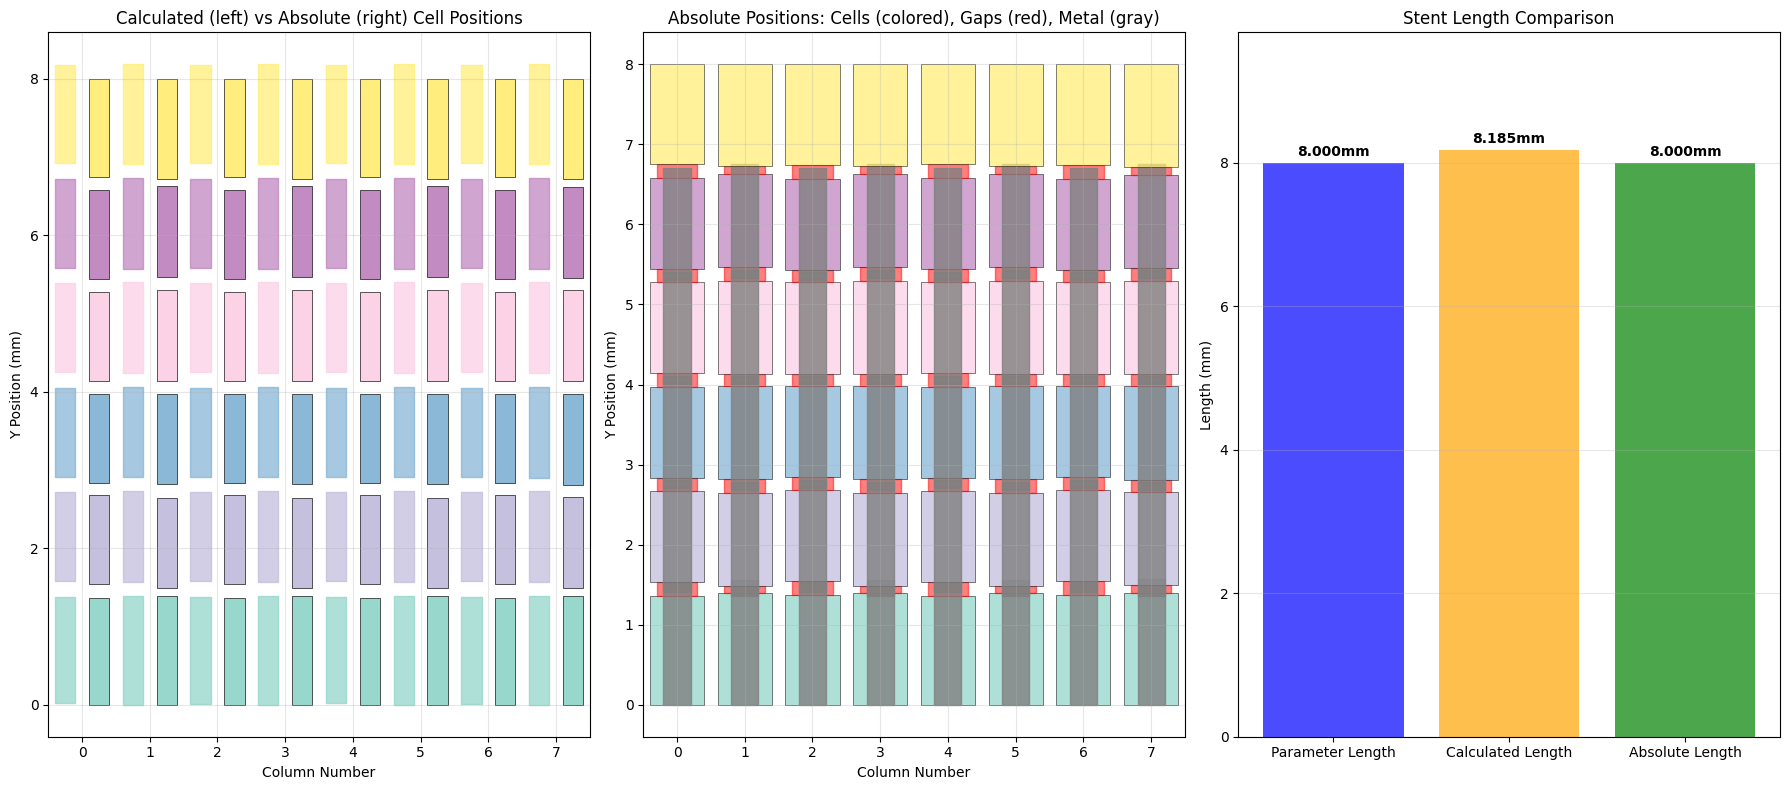


=== SUMMARY COMPARISON ===
Parameter length: 8.000 mm
Calculated length: 8.185 mm
Absolute length: 8.000 mm

Key findings:
1. Absolute positions exactly match the parameter length (8.000 mm)
2. Our calculated positions are 0.185 mm longer
3. The absolute positions provide precise cell borders, gaps, and metal regions
4. Gap sizes vary between rings: [0.175, 0.16, 0.17, 0.16, 0.175]

Exported absolute positions to: D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/absolute_cell_positions.csv


In [12]:
# Create visualization comparing calculated vs absolute positions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))

# Plot 1: Calculated vs Absolute Y positions (side by side)
rings = sorted(new_df_clean['ring'].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(rings)))

# Calculated positions (left side)
for i, ring in enumerate(rings):
    calc_ring_data = cell_positions_df[cell_positions_df['ring'] == ring]
    for idx, row in calc_ring_data.iterrows():
        ax1.fill_between([row['col']-0.4, row['col']-0.1], 
                        row['cell_bottom_y'], row['cell_top_y'], 
                        color=colors[i], alpha=0.7, label=f'Ring {ring}' if idx == calc_ring_data.index[0] else "")

# Absolute positions (right side)
for i, ring in enumerate(rings):
    abs_ring_data = new_df_clean[new_df_clean['ring'] == ring]
    for idx, row in abs_ring_data.iterrows():
        ax1.fill_between([row['col']+0.1, row['col']+0.4], 
                        row['y_top_border_mm'], row['y_bottom_border_mm'], 
                        color=colors[i], alpha=0.9, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Column Number')
ax1.set_ylabel('Y Position (mm)')
ax1.set_title('Calculated (left) vs Absolute (right) Cell Positions')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-0.5, 7.5)

# Plot 2: Gap regions visualization
for i, ring in enumerate(rings):
    abs_ring_data = new_df_clean[new_df_clean['ring'] == ring]
    
    for idx, row in abs_ring_data.iterrows():
        # Cell border
        ax2.fill_between([row['col']-0.4, row['col']+0.4], 
                        row['y_top_border_mm'], row['y_bottom_border_mm'], 
                        color=colors[i], alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Gap regions (if they exist)
        if pd.notna(row['y_bottom_gap_start_mm']) and pd.notna(row['y_bottom_gap_end_mm']):
            ax2.fill_between([row['col']-0.3, row['col']+0.3], 
                            row['y_bottom_gap_start_mm'], row['y_bottom_gap_end_mm'], 
                            color='red', alpha=0.5)
        
        # Metal regions (if different from border)
        if pd.notna(row['y_bottom_metal_mm']):
            if pd.notna(row['y_top_metal_mm']):
                metal_top = row['y_top_metal_mm']
            else:
                metal_top = row['y_top_border_mm']
            
            ax2.fill_between([row['col']-0.2, row['col']+0.2], 
                            metal_top, row['y_bottom_metal_mm'], 
                            color='gray', alpha=0.8)

ax2.set_xlabel('Column Number')
ax2.set_ylabel('Y Position (mm)')
ax2.set_title('Absolute Positions: Cells (colored), Gaps (red), Metal (gray)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.5, 7.5)

# Plot 3: Length comparison chart
length_comparison = {
    'Parameter Length': new_parameters['length_mm'],
    'Calculated Length': calc_length,
    'Absolute Length': abs_length
}

bars = ax3.bar(length_comparison.keys(), length_comparison.values(), 
               color=['blue', 'orange', 'green'], alpha=0.7)

# Add value labels on bars
for bar, value in zip(bars, length_comparison.values()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}mm', ha='center', va='bottom', fontweight='bold')

ax3.set_ylabel('Length (mm)')
ax3.set_title('Stent Length Comparison')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, max(length_comparison.values()) * 1.2)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n=== SUMMARY COMPARISON ===")
print(f"Parameter length: {new_parameters['length_mm']:.3f} mm")
print(f"Calculated length: {calc_length:.3f} mm") 
print(f"Absolute length: {abs_length:.3f} mm")
print(f"")
print(f"Key findings:")
print(f"1. Absolute positions exactly match the parameter length (8.000 mm)")
print(f"2. Our calculated positions are {calc_length - abs_length:.3f} mm longer")
print(f"3. The absolute positions provide precise cell borders, gaps, and metal regions")
print(f"4. Gap sizes vary between rings: {new_df_clean.groupby('ring')['gap_below_mm'].first().dropna().tolist()}")

# Export absolute positions
abs_export_file = r"D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/absolute_cell_positions.csv"
new_df_clean.to_csv(abs_export_file, index=False, float_format='%.6f')
print(f"\nExported absolute positions to: {abs_export_file}")

In [13]:
# Create comprehensive table of all metal gaps
print("=== COMPREHENSIVE METAL GAPS TABLE ===\n")

# Create detailed gap analysis
gap_analysis = []

for ring in sorted(new_df_clean['ring'].unique()):
    ring_data = new_df_clean[new_df_clean['ring'] == ring].copy()
    
    for idx, row in ring_data.iterrows():
        gap_info = {
            'Ring': row['ring'],
            'Column': row['col'],
            'Cell_Bottom_Border': row['y_top_border_mm'],
            'Cell_Top_Border': row['y_bottom_border_mm'],
            'Cell_Height': row['y_bottom_border_mm'] - row['y_top_border_mm'],
            'Metal_Bottom': row['y_bottom_metal_mm'] if pd.notna(row['y_bottom_metal_mm']) else None,
            'Metal_Top': row['y_top_metal_mm'] if pd.notna(row['y_top_metal_mm']) else None,
            'Gap_Start': row['y_bottom_gap_start_mm'] if pd.notna(row['y_bottom_gap_start_mm']) else None,
            'Gap_End': row['y_bottom_gap_end_mm'] if pd.notna(row['y_bottom_gap_end_mm']) else None,
            'Gap_Size': None,
            'Metal_Extension_Below': None,
            'Metal_Extension_Above': None
        }
        
        # Calculate gap size
        if gap_info['Gap_Start'] is not None and gap_info['Gap_End'] is not None:
            gap_info['Gap_Size'] = gap_info['Gap_End'] - gap_info['Gap_Start']
        
        # Calculate metal extensions beyond cell borders
        if gap_info['Metal_Bottom'] is not None:
            gap_info['Metal_Extension_Below'] = gap_info['Metal_Bottom'] - gap_info['Cell_Top_Border']
        
        if gap_info['Metal_Top'] is not None:
            gap_info['Metal_Extension_Above'] = gap_info['Cell_Bottom_Border'] - gap_info['Metal_Top']
        
        gap_analysis.append(gap_info)

# Convert to DataFrame for easier display
gaps_df = pd.DataFrame(gap_analysis)

# Display the comprehensive table
print("Complete Metal Gaps Table:")
print("=" * 140)
print(f"{'Ring':<4} {'Col':<3} {'Cell Bottom':<12} {'Cell Top':<10} {'Cell Height':<12} {'Metal Top':<11} {'Metal Bottom':<13} {'Gap Start':<11} {'Gap End':<9} {'Gap Size':<9} {'Metal Ext Below':<16} {'Metal Ext Above':<16}")
print("=" * 140)

for idx, row in gaps_df.iterrows():
    ring = f"{row['Ring']:.0f}"
    col = f"{row['Column']:.0f}"
    cell_bottom = f"{row['Cell_Bottom_Border']:.3f}" if pd.notna(row['Cell_Bottom_Border']) else "None"
    cell_top = f"{row['Cell_Top_Border']:.3f}" if pd.notna(row['Cell_Top_Border']) else "None"
    cell_height = f"{row['Cell_Height']:.3f}" if pd.notna(row['Cell_Height']) else "None"
    metal_top = f"{row['Metal_Top']:.3f}" if pd.notna(row['Metal_Top']) else "None"
    metal_bottom = f"{row['Metal_Bottom']:.3f}" if pd.notna(row['Metal_Bottom']) else "None"
    gap_start = f"{row['Gap_Start']:.3f}" if pd.notna(row['Gap_Start']) else "None"
    gap_end = f"{row['Gap_End']:.3f}" if pd.notna(row['Gap_End']) else "None"
    gap_size = f"{row['Gap_Size']:.3f}" if pd.notna(row['Gap_Size']) else "None"
    metal_ext_below = f"{row['Metal_Extension_Below']:.3f}" if pd.notna(row['Metal_Extension_Below']) else "None"
    metal_ext_above = f"{row['Metal_Extension_Above']:.3f}" if pd.notna(row['Metal_Extension_Above']) else "None"
    
    print(f"{ring:<4} {col:<3} {cell_bottom:<12} {cell_top:<10} {cell_height:<12} {metal_top:<11} {metal_bottom:<13} {gap_start:<11} {gap_end:<9} {gap_size:<9} {metal_ext_below:<16} {metal_ext_above:<16}")

print("=" * 140)

# Summary statistics
print(f"\n=== GAP STATISTICS SUMMARY ===")
print(f"Total cells analyzed: {len(gaps_df)}")

# Gap size statistics
valid_gaps = gaps_df['Gap_Size'].dropna()
if len(valid_gaps) > 0:
    print(f"\nGap Size Statistics:")
    print(f"  Number of gaps: {len(valid_gaps)}")
    print(f"  Minimum gap size: {valid_gaps.min():.3f} mm")
    print(f"  Maximum gap size: {valid_gaps.max():.3f} mm")
    print(f"  Average gap size: {valid_gaps.mean():.3f} mm")
    print(f"  Gap size std dev: {valid_gaps.std():.3f} mm")

# Metal extension statistics
valid_ext_below = gaps_df['Metal_Extension_Below'].dropna()
valid_ext_above = gaps_df['Metal_Extension_Above'].dropna()

if len(valid_ext_below) > 0:
    print(f"\nMetal Extension Below Cell Statistics:")
    print(f"  Number of extensions: {len(valid_ext_below)}")
    print(f"  Minimum extension: {valid_ext_below.min():.3f} mm")
    print(f"  Maximum extension: {valid_ext_below.max():.3f} mm")
    print(f"  Average extension: {valid_ext_below.mean():.3f} mm")

if len(valid_ext_above) > 0:
    print(f"\nMetal Extension Above Cell Statistics:")
    print(f"  Number of extensions: {len(valid_ext_above)}")
    print(f"  Minimum extension: {valid_ext_above.min():.3f} mm")
    print(f"  Maximum extension: {valid_ext_above.max():.3f} mm")
    print(f"  Average extension: {valid_ext_above.mean():.3f} mm")

# Gap analysis by ring
print(f"\n=== GAP ANALYSIS BY RING ===")
for ring in sorted(gaps_df['Ring'].unique()):
    ring_gaps = gaps_df[gaps_df['Ring'] == ring]['Gap_Size'].dropna()
    ring_metal_below = gaps_df[gaps_df['Ring'] == ring]['Metal_Extension_Below'].dropna()
    
    if len(ring_gaps) > 0:
        print(f"Ring {ring:.0f}:")
        print(f"  Gap sizes: {ring_gaps.min():.3f} to {ring_gaps.max():.3f} mm (avg: {ring_gaps.mean():.3f} mm)")
        if len(ring_metal_below) > 0:
            print(f"  Metal extensions below: {ring_metal_below.min():.3f} to {ring_metal_below.max():.3f} mm (avg: {ring_metal_below.mean():.3f} mm)")

# Export the gap analysis table
gap_export_file = r"D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/metal_gaps_analysis.csv"
gaps_df.to_csv(gap_export_file, index=False, float_format='%.6f')
print(f"\n=== EXPORT ===")
print(f"Exported metal gaps analysis to: {gap_export_file}")

# Create a focused gap table (only showing cells with gaps)
gaps_only = gaps_df[gaps_df['Gap_Size'].notna()].copy()
if len(gaps_only) > 0:
    print(f"\n=== CELLS WITH GAPS ONLY ===")
    print("=" * 100)
    print(f"{'Ring':<4} {'Col':<3} {'Gap Start':<11} {'Gap End':<9} {'Gap Size':<9} {'Cell Bottom':<12} {'Cell Top':<10}")
    print("=" * 100)
    
    for idx, row in gaps_only.iterrows():
        ring = f"{row['Ring']:.0f}"
        col = f"{row['Column']:.0f}"
        gap_start = f"{row['Gap_Start']:.3f}"
        gap_end = f"{row['Gap_End']:.3f}"
        gap_size = f"{row['Gap_Size']:.3f}"
        cell_bottom = f"{row['Cell_Bottom_Border']:.3f}"
        cell_top = f"{row['Cell_Top_Border']:.3f}"
        
        print(f"{ring:<4} {col:<3} {gap_start:<11} {gap_end:<9} {gap_size:<9} {cell_bottom:<12} {cell_top:<10}")
    
    print("=" * 100)
    print(f"Total cells with gaps: {len(gaps_only)}")
else:
    print(f"\nNo cells with defined gaps found.")

=== COMPREHENSIVE METAL GAPS TABLE ===

Complete Metal Gaps Table:
Ring Col Cell Bottom  Cell Top   Cell Height  Metal Top   Metal Bottom  Gap Start   Gap End   Gap Size  Metal Ext Below  Metal Ext Above 
1    0   0.000        1.364      1.364        None        1.534         1.364       1.539     0.175     0.171            None            
1    1   0.000        1.391      1.391        None        1.562         1.391       1.486     0.095     0.171            None            
1    2   0.000        1.366      1.366        None        1.536         1.366       1.541     0.175     0.171            None            
1    3   0.000        1.391      1.391        None        1.562         1.391       1.486     0.095     0.171            None            
1    4   0.000        1.364      1.364        None        1.534         1.364       1.539     0.175     0.171            None            
1    5   0.000        1.391      1.391        None        1.562         1.391       1.486     0.095     0

In [14]:
# Create focused summary tables
print("=== KEY GAP INFORMATION SUMMARY ===\n")

# 1. Gap Summary by Ring
print("1. GAP SUMMARY BY RING:")
print("=" * 60)
print(f"{'Ring':<6} {'Cells with Gaps':<15} {'Gap Range (mm)':<20} {'Avg Gap (mm)':<12}")
print("=" * 60)

for ring in sorted(gaps_df['Ring'].unique()):
    ring_data = gaps_df[gaps_df['Ring'] == ring]
    ring_gaps = ring_data['Gap_Size'].dropna()
    
    if len(ring_gaps) > 0:
        gap_range = f"{ring_gaps.min():.3f} - {ring_gaps.max():.3f}"
        avg_gap = f"{ring_gaps.mean():.3f}"
        cells_with_gaps = len(ring_gaps)
    else:
        gap_range = "No gaps"
        avg_gap = "N/A"
        cells_with_gaps = 0
    
    print(f"{ring:<6.0f} {cells_with_gaps:<15} {gap_range:<20} {avg_gap:<12}")

print("=" * 60)

# 2. Inter-ring Gap Analysis (gaps between rings)
print(f"\n2. INTER-RING GAP ANALYSIS:")
print("=" * 80)
print(f"{'Between Rings':<15} {'Gap Start':<12} {'Gap End':<10} {'Gap Size':<12} {'Gap Type':<15}")
print("=" * 80)

ring_boundaries = {}
for ring in sorted(gaps_df['Ring'].unique()):
    ring_data = gaps_df[gaps_df['Ring'] == ring]
    ring_boundaries[ring] = {
        'min_cell_bottom': ring_data['Cell_Bottom_Border'].min(),
        'max_cell_top': ring_data['Cell_Top_Border'].max(),
        'gap_start': ring_data['Gap_Start'].dropna().min() if len(ring_data['Gap_Start'].dropna()) > 0 else None,
        'gap_end': ring_data['Gap_End'].dropna().max() if len(ring_data['Gap_End'].dropna()) > 0 else None
    }

rings_list = sorted(ring_boundaries.keys())
for i in range(len(rings_list) - 1):
    ring1 = rings_list[i]
    ring2 = rings_list[i + 1]
    
    ring1_top = ring_boundaries[ring1]['max_cell_top']
    ring2_bottom = ring_boundaries[ring2]['min_cell_bottom']
    
    if ring1_top is not None and ring2_bottom is not None:
        inter_ring_gap = ring2_bottom - ring1_top
        gap_type = "Inter-ring space"
        
        print(f"{ring1:.0f} -> {ring2:.0f}      {ring1_top:<12.3f} {ring2_bottom:<10.3f} {inter_ring_gap:<12.3f} {gap_type:<15}")

print("=" * 80)

# 3. Metal Extension Summary
print(f"\n3. METAL EXTENSION SUMMARY:")
print("=" * 70)
print(f"{'Ring':<6} {'Cells w/ Ext Below':<18} {'Avg Ext Below':<15} {'Max Ext Below':<15}")
print("=" * 70)

for ring in sorted(gaps_df['Ring'].unique()):
    ring_data = gaps_df[gaps_df['Ring'] == ring]
    ext_below = ring_data['Metal_Extension_Below'].dropna()
    
    if len(ext_below) > 0:
        cells_with_ext = len(ext_below)
        avg_ext = ext_below.mean()
        max_ext = ext_below.max()
        print(f"{ring:<6.0f} {cells_with_ext:<18} {avg_ext:<15.3f} {max_ext:<15.3f}")
    else:
        print(f"{ring:<6.0f} {'0':<18} {'N/A':<15} {'N/A':<15}")

print("=" * 70)

# 4. Quick reference table for cells with largest gaps
print(f"\n4. CELLS WITH LARGEST GAPS (Top 10):")
print("=" * 50)
print(f"{'Ring':<6} {'Col':<5} {'Gap Size':<12}")
print("=" * 50)

largest_gaps = gaps_df[gaps_df['Gap_Size'].notna()].nlargest(10, 'Gap_Size')
for idx, row in largest_gaps.iterrows():
    print(f"{row['Ring']:<6.0f} {row['Column']:<5.0f} {row['Gap_Size']:<12.3f}")

print("=" * 50)

# 5. Overall statistics
total_gaps = gaps_df['Gap_Size'].dropna()
total_extensions = gaps_df['Metal_Extension_Below'].dropna()

print(f"\n5. OVERALL STATISTICS:")
print(f"   Total cells: {len(gaps_df)}")
print(f"   Cells with gaps: {len(total_gaps)}")
print(f"   Cells with metal extensions: {len(total_extensions)}")
print(f"   Average gap size: {total_gaps.mean():.3f} mm")
print(f"   Total gap volume: {total_gaps.sum():.3f} mm")
print(f"   Average metal extension: {total_extensions.mean():.3f} mm")

print(f"\nExported detailed analysis to: {gap_export_file}")

=== KEY GAP INFORMATION SUMMARY ===

1. GAP SUMMARY BY RING:
Ring   Cells with Gaps Gap Range (mm)       Avg Gap (mm)
1      8               0.095 - 0.175        0.135       
2      8               0.160 - 0.170        0.164       
3      8               0.160 - 0.170        0.162       
4      8               0.160 - 0.170        0.164       
5      8               0.100 - 0.175        0.137       
6      0               No gaps              N/A         

2. INTER-RING GAP ANALYSIS:
Between Rings   Gap Start    Gap End    Gap Size     Gap Type       
1 -> 2      1.395        1.486      0.091        Inter-ring space
2 -> 3      2.679        2.813      0.134        Inter-ring space
3 -> 4      3.977        4.135      0.159        Inter-ring space
4 -> 5      5.298        5.435      0.137        Inter-ring space
5 -> 6      6.625        6.721      0.097        Inter-ring space

3. METAL EXTENSION SUMMARY:
Ring   Cells w/ Ext Below Avg Ext Below   Max Ext Below  
1      8                 

In [15]:
# Calculate gaps between outer curves of crowns as arrays
print("=== CROWN OUTER CURVE GAP ANALYSIS ===\n")

# Extract crown geometry data from the absolute positions
crown_gap_data = []

# Process each ring to calculate crown-to-crown gaps
for ring in sorted(new_df_clean['ring'].unique()):
    ring_data = new_df_clean[new_df_clean['ring'] == ring].copy().sort_values('col')
    
    print(f"Ring {ring} Crown Analysis:")
    print("-" * 50)
    
    # Arrays to store gap information for this ring
    ring_gaps = []
    crown_positions = []
    crown_outer_sagitta = []
    
    # Get crown data
    for idx, row in ring_data.iterrows():
        col = row['col']
        
        # Crown center position and geometry
        crown_center_y = (row['y_top_border_mm'] + row['y_bottom_border_mm']) / 2
        crown_height = row['y_bottom_border_mm'] - row['y_top_border_mm']
        
        # Outer sagitta (crown curve extent)
        upper_outer_sagitta = row['upper_outer_sagitta_mm'] if pd.notna(row['upper_outer_sagitta_mm']) else 0
        lower_outer_sagitta = row['lower_outer_sagitta_mm'] if pd.notna(row['lower_outer_sagitta_mm']) else 0
        
        crown_positions.append({
            'col': col,
            'center_y': crown_center_y,
            'height': crown_height,
            'top_border': row['y_top_border_mm'],
            'bottom_border': row['y_bottom_border_mm'],
            'upper_outer_sagitta': upper_outer_sagitta,
            'lower_outer_sagitta': lower_outer_sagitta,
            'max_outer_extent': max(upper_outer_sagitta, lower_outer_sagitta)
        })
        
        crown_outer_sagitta.append(max(upper_outer_sagitta, lower_outer_sagitta))
    
    # Calculate gaps between adjacent crowns
    for i in range(len(crown_positions)):
        current_crown = crown_positions[i]
        next_crown = crown_positions[(i + 1) % len(crown_positions)]  # Wrap around for last crown
        
        # Calculate the gap between crown outer curves
        # This is the distance between the bottom of current crown and top of next crown
        # minus the outer curve extensions
        
        if i < len(crown_positions) - 1:
            # Normal adjacent crowns
            crown_to_crown_gap = next_crown['top_border'] - current_crown['bottom_border']
            gap_type = "Adjacent"
        else:
            # Last crown to first crown (wrap-around) - this is the inter-ring gap
            crown_to_crown_gap = ring_data['y_bottom_gap_start_mm'].iloc[0] - current_crown['bottom_border']
            gap_type = "To next ring"
        
        # Account for outer curve extensions
        effective_gap = crown_to_crown_gap - current_crown['max_outer_extent'] - next_crown['max_outer_extent']
        
        gap_info = {
            'ring': ring,
            'crown_from': current_crown['col'],
            'crown_to': next_crown['col'],
            'gap_type': gap_type,
            'raw_gap': crown_to_crown_gap,
            'current_outer_extent': current_crown['max_outer_extent'],
            'next_outer_extent': next_crown['max_outer_extent'],
            'effective_gap': effective_gap,
            'gap_start_y': current_crown['bottom_border'] + current_crown['max_outer_extent'],
            'gap_end_y': next_crown['top_border'] - next_crown['max_outer_extent']
        }
        
        ring_gaps.append(gap_info)
        crown_gap_data.append(gap_info)
    
    # Convert to arrays for this ring
    ring_gaps_array = [gap['effective_gap'] for gap in ring_gaps if gap['gap_type'] == "Adjacent"]
    ring_raw_gaps_array = [gap['raw_gap'] for gap in ring_gaps if gap['gap_type'] == "Adjacent"]
    ring_outer_extents_array = [crown['max_outer_extent'] for crown in crown_positions]
    
    print(f"Crown outer curve extents: {np.array(ring_outer_extents_array)}")
    print(f"Raw gaps between crowns: {np.array(ring_raw_gaps_array)}")
    print(f"Effective gaps (after outer curves): {np.array(ring_gaps_array)}")
    print(f"Average effective gap: {np.mean(ring_gaps_array):.3f} mm")
    print(f"Gap variation (std dev): {np.std(ring_gaps_array):.3f} mm")
    print()

# Create comprehensive summary table
crown_gaps_df = pd.DataFrame(crown_gap_data)

print("=== CROWN GAP SUMMARY TABLE ===")
print("=" * 120)
print(f"{'Ring':<4} {'From':<4} {'To':<4} {'Type':<12} {'Raw Gap':<8} {'Curr Extent':<12} {'Next Extent':<12} {'Effective Gap':<14} {'Gap Start Y':<12} {'Gap End Y':<10}")
print("=" * 120)

for idx, row in crown_gaps_df.iterrows():
    ring = f"{row['ring']:.0f}"
    crown_from = f"{row['crown_from']:.0f}"
    crown_to = f"{row['crown_to']:.0f}"
    gap_type = row['gap_type']
    raw_gap = f"{row['raw_gap']:.3f}"
    curr_extent = f"{row['current_outer_extent']:.3f}"
    next_extent = f"{row['next_outer_extent']:.3f}"
    eff_gap = f"{row['effective_gap']:.3f}"
    gap_start = f"{row['gap_start_y']:.3f}"
    gap_end = f"{row['gap_end_y']:.3f}"
    
    print(f"{ring:<4} {crown_from:<4} {crown_to:<4} {gap_type:<12} {raw_gap:<8} {curr_extent:<12} {next_extent:<12} {eff_gap:<14} {gap_start:<12} {gap_end:<10}")

print("=" * 120)

# Create arrays by ring for easy access
print(f"\n=== CROWN GAP ARRAYS BY RING ===")
crown_gap_arrays = {}

for ring in sorted(crown_gaps_df['ring'].unique()):
    ring_data = crown_gaps_df[(crown_gaps_df['ring'] == ring) & (crown_gaps_df['gap_type'] == 'Adjacent')]
    
    effective_gaps = ring_data['effective_gap'].values
    raw_gaps = ring_data['raw_gap'].values
    outer_extents_from = ring_data['current_outer_extent'].values
    outer_extents_to = ring_data['next_outer_extent'].values
    
    crown_gap_arrays[f'ring_{ring:.0f}'] = {
        'effective_gaps': effective_gaps,
        'raw_gaps': raw_gaps,
        'outer_extents_from': outer_extents_from,
        'outer_extents_to': outer_extents_to
    }
    
    print(f"\nRing {ring:.0f}:")
    print(f"  Effective gaps array: {effective_gaps}")
    print(f"  Raw gaps array: {raw_gaps}")
    print(f"  From crown outer extents: {outer_extents_from}")
    print(f"  To crown outer extents: {outer_extents_to}")

# Statistical summary
print(f"\n=== STATISTICAL SUMMARY ===")
adjacent_gaps = crown_gaps_df[crown_gaps_df['gap_type'] == 'Adjacent']

print(f"Total adjacent crown gaps: {len(adjacent_gaps)}")
print(f"Effective gap statistics:")
print(f"  Min: {adjacent_gaps['effective_gap'].min():.3f} mm")
print(f"  Max: {adjacent_gaps['effective_gap'].max():.3f} mm")
print(f"  Mean: {adjacent_gaps['effective_gap'].mean():.3f} mm")
print(f"  Std Dev: {adjacent_gaps['effective_gap'].std():.3f} mm")

print(f"\nOuter curve extent statistics:")
print(f"  Min: {adjacent_gaps['current_outer_extent'].min():.3f} mm")
print(f"  Max: {adjacent_gaps['current_outer_extent'].max():.3f} mm")
print(f"  Mean: {adjacent_gaps['current_outer_extent'].mean():.3f} mm")

# Export crown gap data
crown_gap_export_file = r"D:/SynologyDrive/Companies/Qurevasc/R&D/StentDesign/spec_files/crown_outer_curve_gaps.csv"
crown_gaps_df.to_csv(crown_gap_export_file, index=False, float_format='%.6f')
print(f"\nExported crown gap analysis to: {crown_gap_export_file}")

# Make arrays easily accessible
print(f"\n=== ACCESSING ARRAYS ===")
print("Crown gap arrays are stored in 'crown_gap_arrays' dictionary:")
print("Available keys:", list(crown_gap_arrays.keys()))
print("\nExample usage:")
print("crown_gap_arrays['ring_1']['effective_gaps']  # Gets effective gaps for ring 1")
print("crown_gap_arrays['ring_1']['raw_gaps']        # Gets raw gaps for ring 1")
print("crown_gap_arrays['ring_1']['outer_extents_from'] # Gets outer curve extents")

=== CROWN OUTER CURVE GAP ANALYSIS ===

Ring 1 Crown Analysis:
--------------------------------------------------
Crown outer curve extents: [0.170507 0.170757 0.170525 0.170757 0.170507 0.170757 0.170525 0.170791]
Raw gaps between crowns: [-1.36381  -1.391429 -1.365714 -1.391429 -1.36381  -1.391429 -1.365714]
Effective gaps (after outer curves): [-1.705074 -1.732711 -1.706996 -1.732693 -1.705074 -1.732711 -1.70703 ]
Average effective gap: -1.717 mm
Gap variation (std dev): 0.013 mm

Ring 2 Crown Analysis:
--------------------------------------------------
Crown outer curve extents: [0.131916 0.132377 0.131948 0.132377 0.131916 0.132377 0.131948 0.132439]
Raw gaps between crowns: [-1.188888 -1.105238 -1.192381 -1.107142 -1.188888 -1.105238 -1.188572]
Effective gaps (after outer curves): [-1.453181 -1.369563 -1.456706 -1.371435 -1.453181 -1.369563 -1.452959]
Average effective gap: -1.418 mm
Gap variation (std dev): 0.042 mm

Ring 3 Crown Analysis:
---------------------------------------

In [16]:
# Display crown gap arrays in concise format
print("=== CROWN OUTER CURVE GAP ARRAYS ===\n")

# Display the arrays for each ring
for ring_key, arrays in crown_gap_arrays.items():
    ring_num = ring_key.split('_')[1]
    print(f"Ring {ring_num}:")
    print(f"  Effective gaps between crown outer curves:")
    print(f"    {arrays['effective_gaps']}")
    print(f"  Raw gaps (before accounting for curves):")
    print(f"    {arrays['raw_gaps']}")
    print(f"  Crown outer curve extents:")
    print(f"    {arrays['outer_extents_from']}")
    print()

# Summary statistics in array format
print("=== SUMMARY ARRAYS ===")
all_effective_gaps = []
all_raw_gaps = []
all_outer_extents = []

for arrays in crown_gap_arrays.values():
    all_effective_gaps.extend(arrays['effective_gaps'])
    all_raw_gaps.extend(arrays['raw_gaps'])
    all_outer_extents.extend(arrays['outer_extents_from'])

print(f"All effective gaps: {np.array(all_effective_gaps)}")
print(f"All raw gaps: {np.array(all_raw_gaps)}")
print(f"All outer curve extents: {np.array(all_outer_extents)}")

print(f"\nStatistics:")
print(f"  Mean effective gap: {np.mean(all_effective_gaps):.3f} mm")
print(f"  Min effective gap: {np.min(all_effective_gaps):.3f} mm")
print(f"  Max effective gap: {np.max(all_effective_gaps):.3f} mm")
print(f"  Gap std deviation: {np.std(all_effective_gaps):.3f} mm")

print(f"\n  Mean outer curve extent: {np.mean(all_outer_extents):.3f} mm")
print(f"  Min outer curve extent: {np.min(all_outer_extents):.3f} mm")
print(f"  Max outer curve extent: {np.max(all_outer_extents):.3f} mm")

=== CROWN OUTER CURVE GAP ARRAYS ===

Ring 1:
  Effective gaps between crown outer curves:
    [-1.705074 -1.732711 -1.706996 -1.732693 -1.705074 -1.732711 -1.70703 ]
  Raw gaps (before accounting for curves):
    [-1.36381  -1.391429 -1.365714 -1.391429 -1.36381  -1.391429 -1.365714]
  Crown outer curve extents:
    [0.170507 0.170757 0.170525 0.170757 0.170507 0.170757 0.170525]

Ring 2:
  Effective gaps between crown outer curves:
    [-1.453181 -1.369563 -1.456706 -1.371435 -1.453181 -1.369563 -1.452959]
  Raw gaps (before accounting for curves):
    [-1.188888 -1.105238 -1.192381 -1.107142 -1.188888 -1.105238 -1.188572]
  Crown outer curve extents:
    [0.131916 0.132377 0.131948 0.132377 0.131916 0.132377 0.131948]

Ring 3:
  Effective gaps between crown outer curves:
    [-1.420166 -1.400991 -1.425278 -1.404452 -1.420166 -1.400991 -1.428355]
  Raw gaps (before accounting for curves):
    [-1.155873 -1.136666 -1.160953 -1.140159 -1.155873 -1.136666 -1.163968]
  Crown outer curve 